## Persiapan Data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

%matplotlib inline
pd.set_option('display.max_columns', None)

Data Description

---
Data factbook transform merupakan data dengan atribut-atribut yang memuat informasi mengenai 149 negara yang berada pada berbagai benua. Pada penugasan Machine Learning ini, kami akan menggunakan beberapa atribut yaitu sebagai berikut :

1. Export : Nilai total barang dan jasa yang diekspor suatu negara dalam dolar AS.
2. Import : Nilai total barang dan jasa yang diimpor suatu negara dalam dolar AS.
3. Industrial production growth rate : Tingkat pertumbuhan produksi industri suatu negara dalam satu tahun. Dinyatakan dalam persen.
5. Investment : Total nilai investasi suatu negara dalam dolar AS.
6. Unemployment rate : Persentase angka pengangguran dalam populasi angkatan kerja suatu negara.




In [ ]:
df = pd.read_csv('factbook_tr.csv')

Pengambilan Atribut


---

Melakukan pengambilan data atribut yang diperlukan untuk melakukan klusterisasi

In [ ]:
# Default data data yang digunakan (opsi 1)
df = df[['Exports', 'Imports', 'Industrial production growth rate', 'Investment', 'Unemployment rate']]
df.head()

,Exports,Imports,Industrial production growth rate,Investment,Unemployment rate
0,538800000000,401800000000,6.6,24.0,4.7
1,893300000000,716700000000,2.2,17.6,10.6
2,113000000000,36210000000,2.8,17.2,25.0
3,162500000000,92910000000,6.4,19.1,8.3
4,130700000000,121100000000,4.7,20.4,3.4


Melakukan pengambilan data atribut untuk data 2 dimensi yang diperlukan sebagai alternatif untuk melakukan klusterisasi,
dengan atribut sebagai berikut :
1. Trade Balance : Merupakan penurunan dari atribut exports dan imports
2. Economic Performance : merupakan penurunan dari atribut industrial production growth rate, invesment, dan unemployment rate

In [ ]:
# Alternatif data jika digunakan data 2 dimensi (opsi 2)
df['Trade balance'] = df['Exports'] - df['Imports']
df['Economic performance'] = (df['Industrial production growth rate'] + df['Investment'] + df['Unemployment rate'])
df2 = df[['Trade balance', 'Economic performance']]
df2.head()

,Trade balance,Economic performance
0,137000000000,35.3
1,176600000000,30.4
2,76790000000,45.0
3,69590000000,33.8
4,9600000000,28.5


## Normalisasi Data

Dilakukan normalisasi atau penskalaan data dengan rentang 0-1. Pada proses k-means clustering, proses ini sangat penting untuk memastikan bahwa setiap variabel memiliki skala yang serupa dan tidak mendominasi sehingga mengabaikan pengaruh dari variabel lainnya. Dengan normalisasi, kita dapat melakukan perbandingan dan evaluasi dari setiap variabel

In [ ]:
# Membuat fungsi min-max scaler
def minMax_scaler(df):
    return (df - df.min()) / (df.max() - df.min())

In [ ]:
# Realisasi normalisasi
df = df.apply(minMax_scaler)
df2 = df2.apply(minMax_scaler)

Karena salah satu kelemahan dari algoritma kmeans clustering adalah sensitif terhadap outliers dan kepadatan cluster yang tidak merata, maka akan dilakukan pengecekan outliers dan penggantian outliers

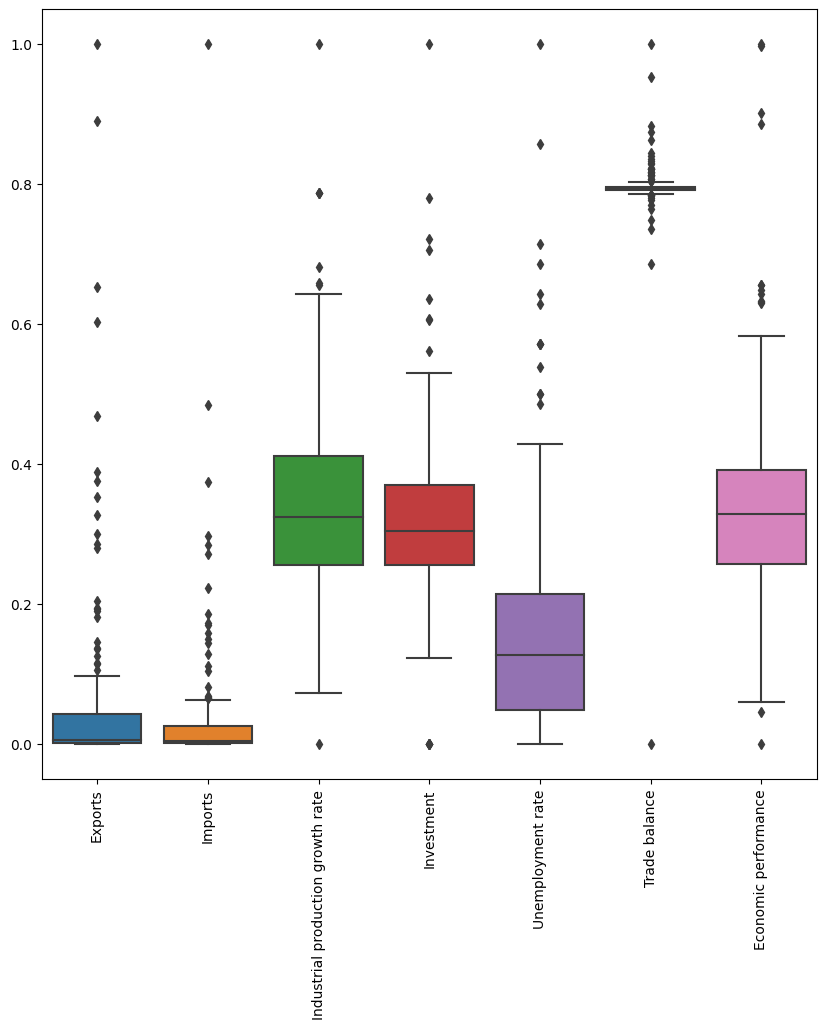

In [ ]:
# Cek boxplot data multi dimensi
plt.figure(figsize=(10, 10))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

Dengan adanya visualisasi boxplot diatas dapat diketahui bahwa terdapat nilai-nilai yang ekstrim atau outliers yang perlu diperhatikan.

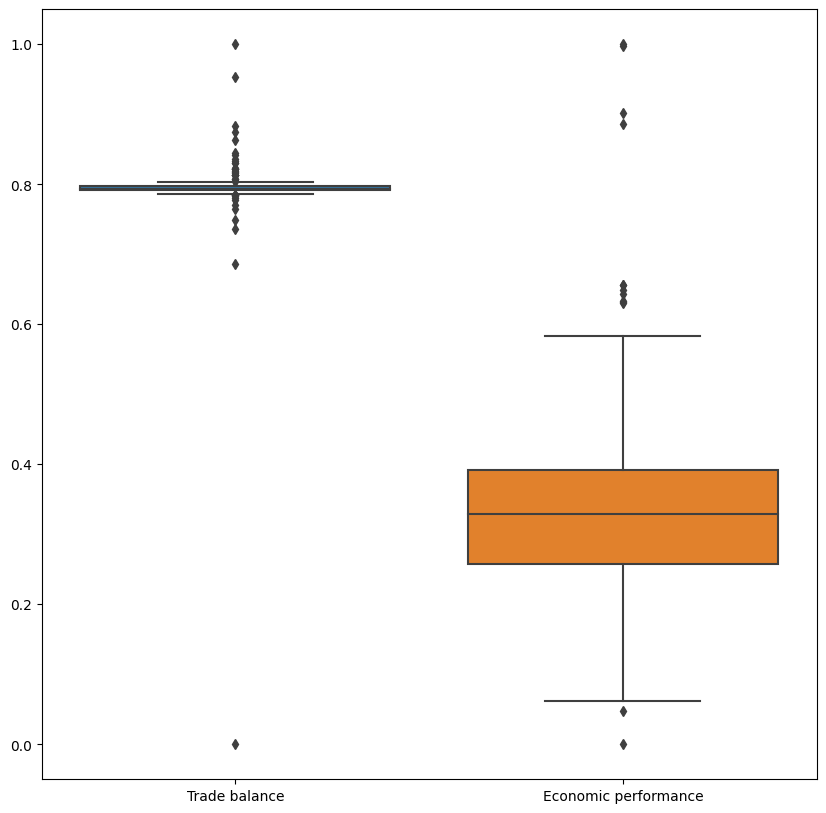

In [ ]:
# cek boxplot data 2 dimensi
plt.figure(figsize=(10, 10))
sns.boxplot(data=df2)
plt.show()

Sama hal nya seperti data sebelumnya, dengan adanya visualisasi dari boxplot diatas pada atribut 2 dimensi yang digunakan sebagai alteratif dapat diketahui bahwa terdapat nilai-nilai yang ekstrim atau outliers yang perlu diperhatikan.

Menggantikan nilai outliers dengan threshold


---
Dilakukan penggantian nilai outliers dengan menggunakan threshold yang ditentukan, outliers dapat dihilangkan atau diubah menjadi nilai yang lebih tepat sesuai dengan rentang data yang ada. Hal ini dapat membantu dalam  menghindari pengaruh outliers pada analisis data. Hal ini dilakukan karena kelemahan dari algoritma kmeans clustering adalah sensitif terhadap outliers dan kepadatan cluster yang tidak merata. Dalam kasus ini, kami mengubah nilai yang diluar outliers menjadi nilai maksimum dari up_limit dan nilai minimum dari low_limit

In [ ]:
# Menggantikan nilai outliers dengan threshold
def outlier_threshold(df, col, q1=0.25, q3=0.75):
    quartile1 = df[col].quantile(q1)
    quartile3 = df[col].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_threshold(df, col):
    low, up = outlier_threshold(df, col)
    df[col] = np.where(df[col] > up, up, np.where(df[col] < low, low, df[col]))
    return df

for i in df.columns:
    df = replace_with_threshold(df, i)

for i in df2.columns:
    df2 = replace_with_threshold(df2, i)

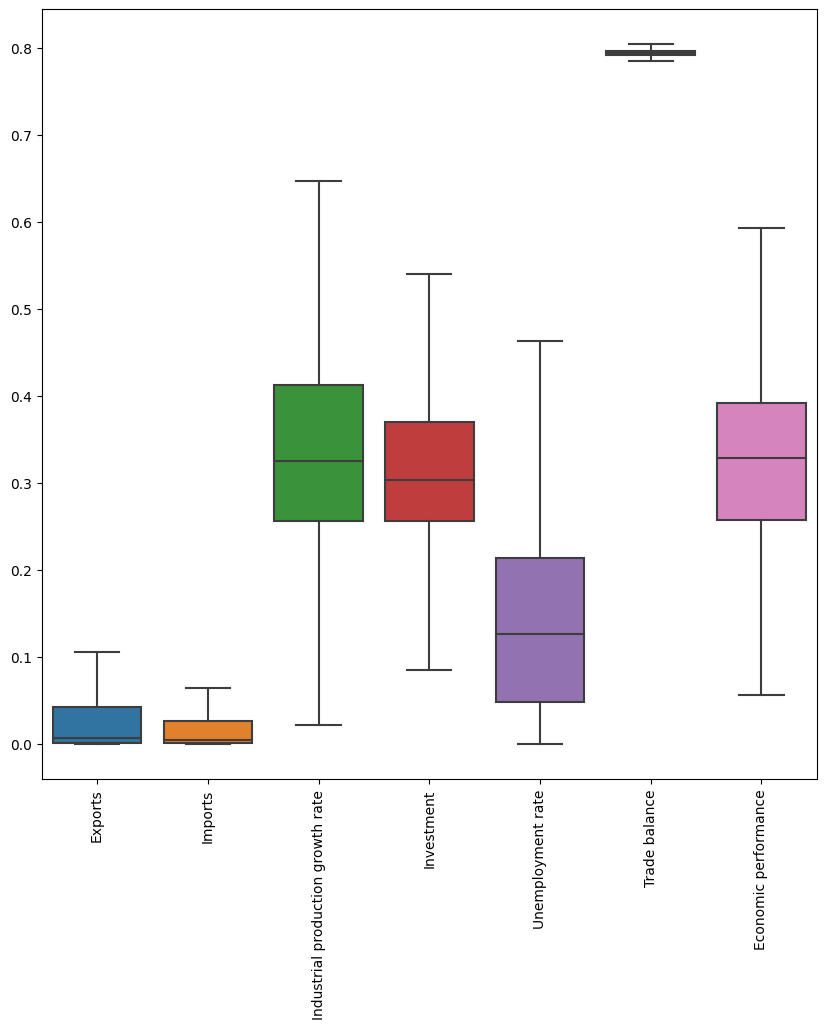

In [ ]:
# Cek boxplot data multi dimensi
plt.figure(figsize=(10, 10))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

Setelah dilakukan penggantian nilai outliers dengan menggunakan threshold dilakukan pengecekan kembali pada data dengan menggunakan visualisasi boxplot. Dari hasil visualisasi dapat diketahui bahwa sudah tidak terdapat outliers pada data.

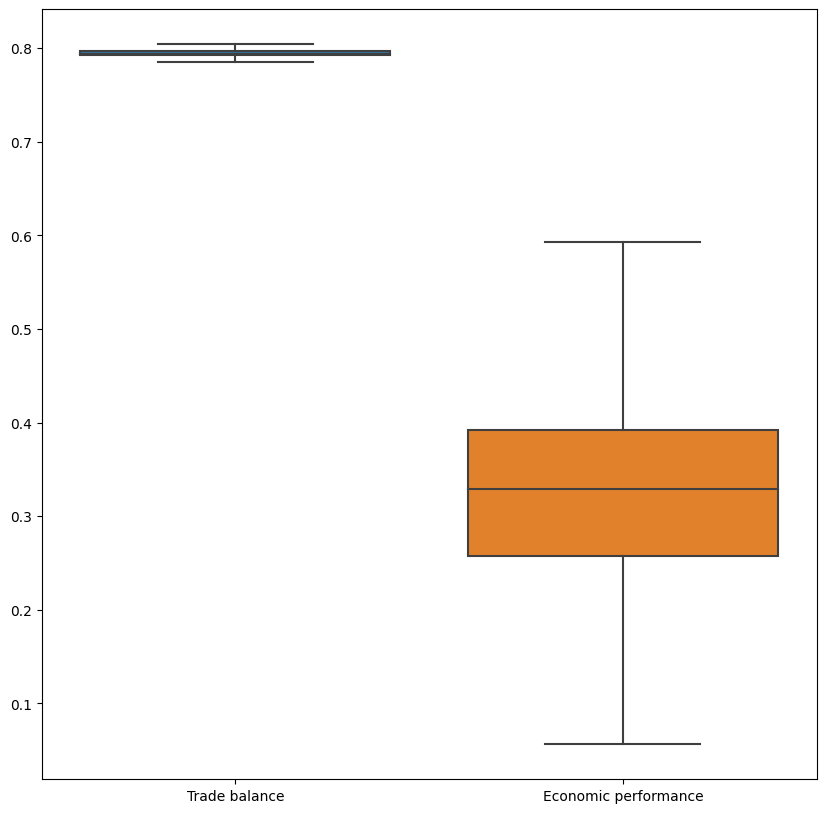

In [ ]:
# cek boxplot data 2 dimensi
plt.figure(figsize=(10, 10))
sns.boxplot(data=df2)
plt.show()

Setelah dilakukan penggantian nilai outliers dengan menggunakan threshold dilakukan juga pengecekan kembali pada data dengan atribut 2 dimensi yang digunakan sebagai alternatif dengan menggunakan visualisasi boxplot. Dari hasil visualisasi dapat diketahui bahwa sudah tidak terdapat outliers pada data.

## Mendefinisikan Fungsi

Langkah langkah sederhana untuk membuat algoritma k-means clustering adalah sebagai berikut:
1. Inisialisasi centroid awal
2. Mengelompokkan data ke dalam cluster
3. Memperbarui posisi centroid dan menghitungnya hingga konvergen
4. Menghitung perbedaan posisi centroid lama dengan baru
5. Evaluasi hasil klasterisasi

In [ ]:
# Membuat centroid secara random sebanyak k dari dataset
def random_centroid(df, k):
    centroid = []
    for _ in range(k):
        centroid.append(df.sample().values[0])
    return centroid

Membuat centroid secara acak sebanyak k dari dataset yang ada. Hal ini penting karena centroid awal dibutuhkan untuk memulai proses klastering. Pembentukan centroid secara acak memberikan variasi awal yang diperlukan untuk mencapai hasil klastering yang lebih baik.

In [ ]:
# Mendefinisikan cluster menggunakan euclidean distance
def assign_cluster(df, initial_centroid, k):
    cluster = []
    for i in range(len(df)):
        euclidean_distance = []
        for j in range(k):
            euclidean_distance.append(np.linalg.norm(np.subtract(df.iloc[i], initial_centroid[j])))
        cluster.append(np.argmin(euclidean_distance))
    return cluster

selanjutnya setiap data ditetapkan ke cluster berdasarkan jarak Euclidean terhadap centroid awal. Jarak Euclidean digunakan untuk mengukur kedekatan antara data dan centroid. Dengan menetapkan setiap data ke cluster yang sesuai, analisis klastering dapat dilanjutkan untuk mengelompokkan data ke dalam cluster-cluster yang relevan berdasarkan kemiripan mereka. Hal ini memungkinkan untuk membentuk klaster yang mewakili kelompok data yang serupa dan menghasilkan pemisahan yang optimal antara kelompok data yang berbeda.



In [ ]:
# Menghitung centroid hingga konvergen
def compute_centroid(df, cluster, k):
    centroids = []
    for i in range(k):
        temp = []
        for j in range(len(df)):
            if cluster[j] == i:
                temp.append(df.iloc[j])
        centroids.append(np.mean(temp, axis=0))
    return centroids

kemudian dilakukan perhitungan untuk menghitung posisi centroid baru dengan mengambil rata-rata dari data dalam setiap cluster. Hal ini dilakuka untuk mencapai konvergensi algoritma k-means, di mana perubahan posisi centroid menjadi sangat kecil atau tidak ada perubahan yang signifikan.

In [ ]:
# Menghitung perbedaan centroid lama dan centroid baru
def difference(old, new):
    diff = 0
    for i in range(len(old)):
        diff += np.linalg.norm(np.subtract(old[i], new[i]))
    return diff

Proses ini dilakukan untuk mengetahui perbedaan antara centroid lama dan centroid baru. Jika perbedaan antara centroid lama dan centroid baru menjadi sangat kecil atau mendekati nol, itu menunjukkan bahwa centroid telah mencapai posisi yang stabil dan algoritma k-means telah mencapai konvergensi.

# K-Means Clustering

## K-Means Clustering 2 Dimensi

Memvisualisasikan plot cluster dan centroid untuk atribut 2 dimensi


---
Hasil visualisasi akan membantu dalam memahami dan menganalisis hasil dari algoritma klastering, terutama dalam konteks k-means.


In [ ]:
# Menampilkan plot cluster dan centroid (hanya untuk 2 dimensi)
def show_cluster(df, cluster, k, x, y):
    df['cluster'] = cluster
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=x,
                    y=y,
                    hue='cluster',
                    data=df,
                    palette='Set1')
    plt.title(f'K-Means Clustering (k={k})')
    for i in range(k):
        plt.scatter(x=df[df['cluster'] == i][x].mean(),
                    y=df[df['cluster'] == i][y].mean(),
                    s=400, c='black', marker='*')
    plt.show()

In [ ]:
# Memanggil fungsi k-means (hanya untuk 2 dimensi)
def kmeans(df, k, x, y, show_plot=True):
    initial_centroid = random_centroid(df, k)
    cluster = assign_cluster(df, initial_centroid, k)
    new_centroid = compute_centroid(df, cluster, k)
    while difference(initial_centroid, new_centroid) > 0.001:
        initial_centroid = new_centroid
        cluster = assign_cluster(df, initial_centroid, k)
        new_centroid = compute_centroid(df, cluster, k)
    if show_plot:
        show_cluster(df, cluster, k, x, y)
    df['cluster'] = cluster
    return df

Selanjutnya dilakukan klasterisasi menggunakan langkah-langkah utama dari algoritma k-means yaitu seperti inisialisasi centroid, penugasan klaster, perhitungan centroid baru, dan konvergensi. Hal ini dilakukan untuk mempermudah penggunaan algoritma k-means pada data dengan dua dimensi dan menyediakan opsi untuk menampilkan plot klaster untuk visualisasi hasil klastering.

## K-Means Clustering Multi Dimensi

In [ ]:
# Memanggil fungsi k-means (hanya untuk multi dimensi)
def kmeans_grouped(df, k):
    initial_centroid = random_centroid(df, k)
    cluster = assign_cluster(df, initial_centroid, k)
    new_centroid = compute_centroid(df, cluster, k)
    while difference(initial_centroid, new_centroid) > 0.001:
        initial_centroid = new_centroid
        cluster = assign_cluster(df, initial_centroid, k)
        new_centroid = compute_centroid(df, cluster, k)
    df['cluster'] = cluster
    return df

Sama hal nya dengan sebelumnya dilakukan klastering dengan menggunakan algoritma k-means. Namun, fungsi ini dioptimalkan untuk data dengan dimensi lebih dari dua.

## Menghitung Inersia Menggunakan Elbow Method

In [ ]:
# Menghitung wcss inertia untuk setiap cluster
def inertia(df, cluster, k):
    wcss = []
    for i in range(k):
        temp = []
        for j in range(len(df)):
            if cluster[j] == i:
                temp.append(df.iloc[j])
        wcss.append(np.sum(np.linalg.norm(np.subtract(temp, np.mean(temp, axis=0)), axis=1)))
    return np.sum(wcss)

Dilakukan perhitungan wcss inertia untuk setiap cluster yang digunakan untuk mengukur seberapa dekat setiap data dalam klaster dengan centroidnya. Semakin kecil nilai WCSS inertia maka semakin baik klasteringnya, karena menunjukkan bahwa data dalam klaster-klasternya saling berdekatan.

In [ ]:
# Menghitung nilai wcss inertia untuk setiap k
def k_means_inertia(df, n_cluster):
    initial_centroid = random_centroid(df, n_cluster)
    cluster = assign_cluster(df, initial_centroid, n_cluster)
    new_centroid = compute_centroid(df, cluster, n_cluster)
    while difference(initial_centroid, new_centroid) > 0.001:
        initial_centroid = new_centroid
        cluster = assign_cluster(df, initial_centroid, n_cluster)
        new_centroid = compute_centroid(df, cluster, n_cluster)
    return inertia(df, cluster, n_cluster)

Selanjutnya dihitung nilai wcss inertia untuk setiap k untuk menentukan nilai k yang menghasilkan klastering yang paling baik atau paling optimal. Semakin rendah nilai WCSS inertia maka semakin baik klasteringnya, karena menunjukkan bahwa data dalam klaster-klasternya saling berdekatan.


In [ ]:
# Menampilkan visualisasi wcss inertia
def show_visualizer(df, k):
    inertia_list = []
    for i in range(1, k):
        inertia_list.append(k_means_inertia(df, i))

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, k), inertia_list, marker='o')
    for i, v in enumerate(inertia_list):
        plt.text(i+1, v, round(v, 2), ha='center', va='bottom')

    plt.xlabel('Number of cluster')
    plt.ylabel('wcss')
    plt.show()

Dengan menampilkan visualisasi wcss inertia dapat diketahui elbow point atau yang menunjukkan perubahan signifikan dalam nilai WCSS inertia. Elbow point tersebut digunakan untuk memilih jumlah klaster yang optimal.






## Visualisasi Elbow Method dan K-Means

### Visualisasi K-Means Clustering 2 Dimensi

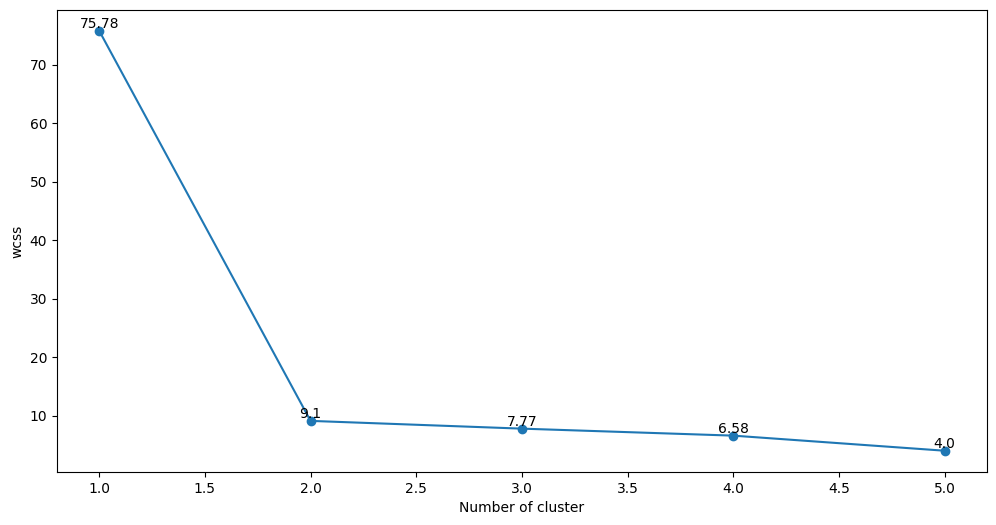

In [ ]:
# Melihat grafik wcss
show_visualizer(df2, 6)

Berdasarkan grafik diatas, dapat dilihat bahwa nilai inertia menurun drastis dari k=1 ke k=2. Oleh karena itu, nilai k yang digunakan adalah 2.

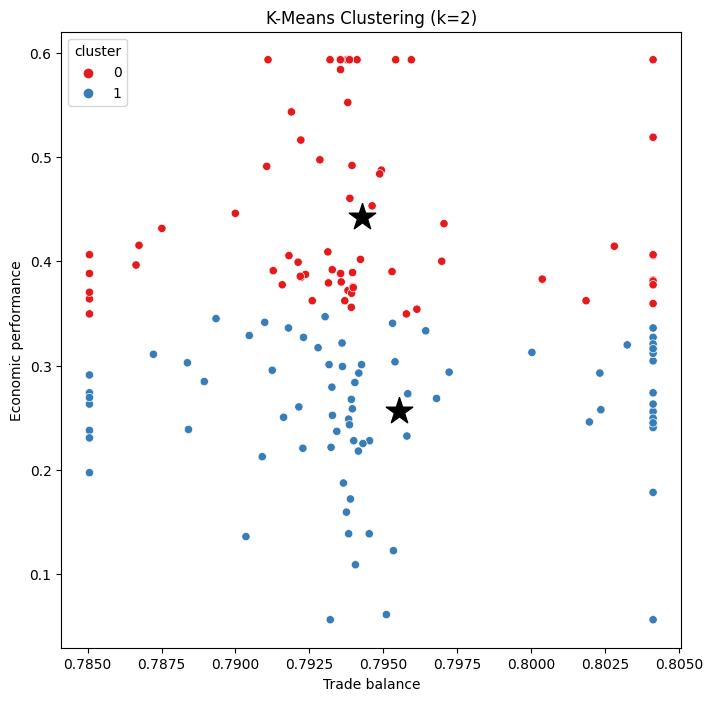

In [ ]:
# Memanggil fungsi k-means
kmeans = kmeans(df2, 2, 'Trade balance', 'Economic performance', show_plot=True)

Dari grafik diatas, kita dapat mengetahui bahwa output dari hasil klasterisasi adalah kelompok-kelompok yang terbentuk berdasarkan pola dan kemiripan data.

In [ ]:
kmeans

,Trade balance,Economic performance,cluster
0,0.804121,0.318018,1
1,0.804121,0.273874,1
2,0.804121,0.405405,0
3,0.804121,0.304505,1
4,0.804121,0.256757,1
...,...,...,...
144,0.802355,0.257658,1
145,0.785063,0.349550,0
146,0.785063,0.197297,1
147,0.785063,0.290991,1


In [ ]:
# Melihat jumlah setiap cluster
df2['cluster'].value_counts()

1    82
0    67
Name: cluster, dtype: int64

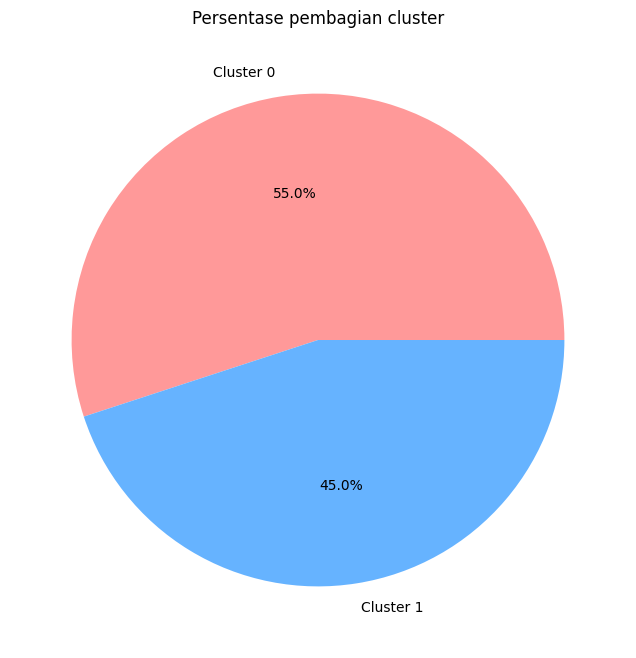

In [ ]:
# Membuat pie chart untuk mengetahui persentase setiap cluster
plt.figure(figsize=(8, 8))
plt.pie(df2['cluster'].value_counts(),
        labels=['Cluster 0', 'Cluster 1'],
        autopct='%1.1f%%',
        colors=['#ff9999', '#66b3ff'])
plt.title('Persentase pembagian cluster')
plt.show()

Hasil dari klasterisasi adalah, 2 model klaster yaitu klaster 1 (0) dan klaster 2 (1), dimana sebanyak 82 data pada klaster 1 dan sebanyak 67 data pada klaster 2 (jika pada data 2 dimensi)

### Visualisasi K-Means Clustering Multi Dimensi

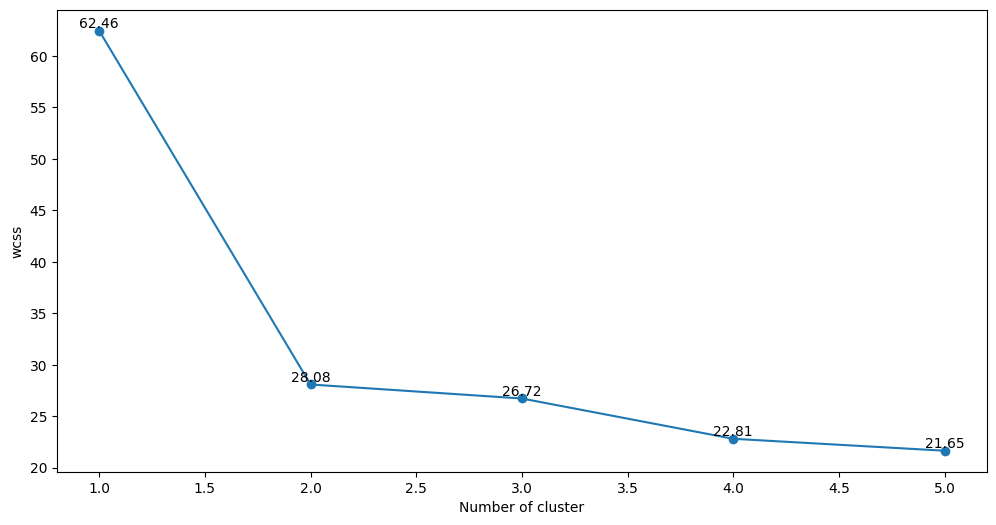

In [ ]:
# Melihat grafik wcss
show_visualizer(df, 6)

Berdasarkan grafik diatas, dapat dilihat bahwa nilai inertia menurun drastis dari k=1 ke k=2. Oleh karena itu, nilai k yang digunakan adalah 2.

In [ ]:
kmeans = kmeans_grouped(df, 2)
kmeans

,Exports,Imports,Industrial production growth rate,Investment,Unemployment rate,Trade balance,Economic performance,cluster
0,0.105816,0.064738,0.380952,0.368664,0.067143,0.804121,0.318018,1
1,0.105816,0.064738,0.264550,0.270353,0.151429,0.804121,0.273874,1
2,0.105816,0.024505,0.280423,0.264209,0.357143,0.804121,0.405405,0
3,0.105816,0.062921,0.375661,0.293395,0.118571,0.804121,0.304505,1
4,0.105816,0.064738,0.330688,0.313364,0.048571,0.804121,0.256757,1
...,...,...,...,...,...,...,...,...
144,0.105816,0.064738,0.224868,0.296467,0.122857,0.802355,0.257658,1
145,0.105816,0.064738,0.285714,0.390169,0.148571,0.785063,0.349550,1
146,0.105816,0.064738,0.230159,0.248848,0.068571,0.785063,0.197297,1
147,0.097262,0.064738,0.256614,0.388633,0.072857,0.785063,0.290991,1


In [ ]:
# Melihat jumlah setiap cluster
kmeans['cluster'].value_counts()

1    117
0     32
Name: cluster, dtype: int64

Hasil dari klasterisasi adalah, 2 model klaster yaitu klaster 1 (0) dan klaster 2 (1), dimana sebanyak 113 data pada klaster 1 dan sebanyak 36 data pada klaster 2 (jika pada data multi dimensi)

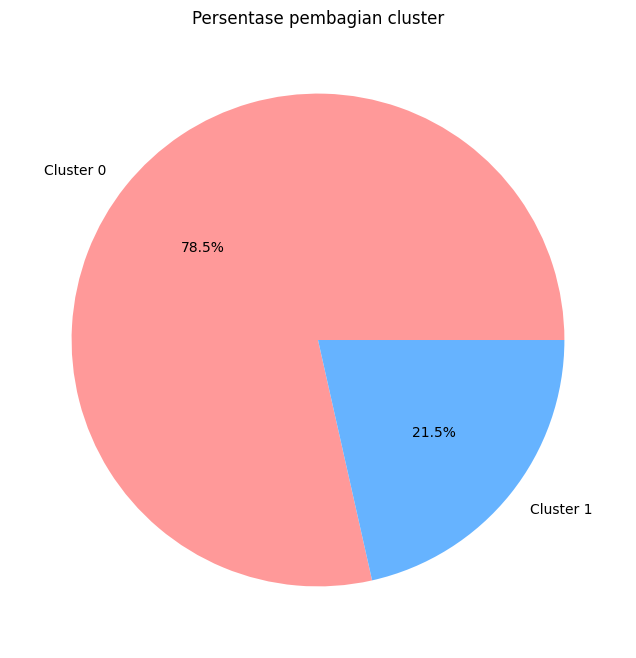

In [ ]:
# Membuat pie chart untuk mengetahui persentase setiap cluster
plt.figure(figsize=(8, 8))
plt.pie(kmeans['cluster'].value_counts(),
        labels=['Cluster 0', 'Cluster 1'],
        autopct='%1.1f%%',
        colors=['#ff9999', '#66b3ff'])
plt.title('Persentase pembagian cluster')
plt.show()